In [1]:
import warnings

warnings.filterwarnings('ignore')

# 2 模仿过程

## 2.1 过程分解

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from tqdm.notebook import tqdm
from pyproj import CRS, Transformer # 单一坐标的投影变换
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

In [3]:
import pandas as pd

# 读入原始上下车点数据
taxi_trip_flow = pd.read_csv('data.csv')
taxi_trip_flow.loc[0] # 以Series形式查看第一行

VendorID                                          2
tpep_pickup_datetime     2015-01-15 19:05:39 +00:00
tpep_dropoff_datetime    2015-01-15 19:23:42 +00:00
passenger_count                                   1
trip_distance                                  1.59
pickup_longitude                           -73.9939
pickup_latitude                             40.7501
dropoff_longitude                          -73.9748
dropoff_latitude                            40.7506
fare_amount                                      12
tip_amount                                     3.25
total_amount                                  17.05
Name: 0, dtype: object

In [4]:
from shapely.geometry import Point
import geopandas as gpd

od_points = \
(
    # 首先合并所有的经纬度信息
    pd
    .concat([taxi_trip_flow[['pickup_longitude', 'pickup_latitude']]
             .rename(columns={'pickup_longitude': 'lng', 
                              'pickup_latitude': 'lat'}),
             taxi_trip_flow[['dropoff_longitude', 'dropoff_latitude']]
             .rename(columns={'dropoff_longitude': 'lng', 
                              'dropoff_latitude': 'lat'})])
    # 对经纬度进行去重
    .drop_duplicates()
)

# 基于经纬度信息为od_points添加矢量信息列
od_points['geometry'] = (
    od_points
    .apply(lambda row: Point(row['lng'], row['lat']), axis=1)
)

# 转换为GeoDataFrame并统一坐标到Web墨卡托
od_points = gpd.GeoDataFrame(od_points, crs='EPSG:4326').to_crs('EPSG:3857')

od_points.head()

,lng,lat,geometry
0,-73.993896,40.750111,POINT (-8236962.878 4975552.617)
1,-73.976425,40.739811,POINT (-8235017.981 4974039.256)
2,-73.968704,40.754246,POINT (-8234158.488 4976160.269)
3,-73.863060,40.769581,POINT (-8222398.228 4978414.068)
4,-73.945541,40.779423,POINT (-8231580.013 4979860.811)


In [5]:
from shapely.geometry import MultiLineString
from shapely.ops import polygonize # 用于将交叉线转换为网格面
import numpy as np

# 提取所有上下车坐标点范围的左下角及右上角坐标信息
xmin, ymin, xmax, ymax = od_points.total_bounds

# 创建x方向上的所有坐标位置
x = np.linspace(xmin, 
                xmax,
                6)

# 创建y方向上的所有坐标位置
y = np.linspace(ymin, 
                ymax,
                6)

# 生成全部交叉线坐标信息
hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(x[:-1], x[1:]) for yi in y]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(y[:-1], y[1:]) for xi in x]

# 创建网格
manhattan_grids = gpd.GeoDataFrame({
    'geometry': list(polygonize(MultiLineString(hlines + vlines)))}, 
    crs='EPSG:3857')

# 添加一一对应得id信息
manhattan_grids['id'] = manhattan_grids.index

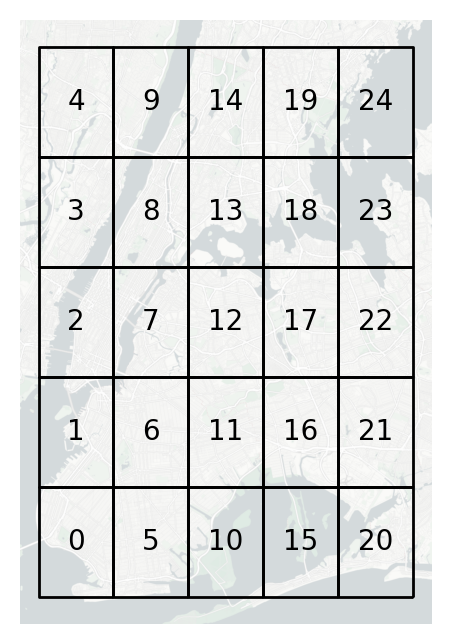

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
ax = manhattan_grids.plot(facecolor='none', edgecolor='black', ax=ax)

# 标注每个网格的id
for row in manhattan_grids.itertuples():
    
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row.id, ha='center', va='center')

# 关闭坐标轴
ax.axis('off')

# 添加carto的素色底图
ctx.add_basemap(ax, 
                source='https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png',
                zoom=12)

fig.savefig('图7.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [7]:
i = 21 # 对应肯尼迪国际机场的网格

# 计算得到所有网格整体的重心坐标
center_grid = (manhattan_grids.unary_union.centroid.x, 
               manhattan_grids.unary_union.centroid.y)

# 提取对应下车点坐标
dropoff = (
    # 利用空间连接，提取目标网格中包含到的所有坐标点
    gpd
    .sjoin(manhattan_grids.loc[i:i, :],
           right_df=od_points, 
           op='contains')
    [['lng', 'lat', 'geometry']]
    # 利用提取到的坐标点信息，关联在目标
    # 网格中上车的记录对应的下车点坐标
    .merge(taxi_trip_flow[['pickup_longitude', 
                           'pickup_latitude', 
                           'dropoff_longitude', 
                           'dropoff_latitude']], 
           left_on=['lng', 'lat'], 
           right_on=['pickup_longitude', 
                     'pickup_latitude'])
    [['dropoff_longitude', 'dropoff_latitude']]
    # 根据匹配到的下车点坐标
    # 与od_points表进行连接
    # 找到对应下车点的矢量信息
    .merge(od_points,
           left_on=['dropoff_longitude', 'dropoff_latitude'],
           right_on=['lng', 'lat'])[['geometry']]
)

# 提取上一步得到的下车坐标点在各个网格中的分布数据
grid_distrib = (
    # 利用空间连接匹配网格与下车坐标点
    gpd
    .sjoin(manhattan_grids,
           # 转换为同一坐标参考系的GeoDataFrame
           gpd.GeoDataFrame(dropoff, crs='EPSG:3857'),
           op='contains')
    # 根据网格id进行分组计数
    .groupby('id', as_index=False)
    .agg({'index_right': 'count'})
    .rename(columns={'index_right': '下车记录数'})
)

grid_distrib.head()

,id,下车记录数
0,0,15
1,1,95
2,2,523
3,3,15
4,5,38


In [8]:
# 利用基本的仿射变换得到原始网格向对应目标网格的嵌入变换

# 获取当前目标网格的重心坐标
center_child_grid = (manhattan_grids.at[i, 'geometry'].centroid.x, 
                     manhattan_grids.at[i, 'geometry'].centroid.y)

# 利用仿射变换得到整体网格在目标网格中的镶嵌
draw_gdf = (
    manhattan_grids
    # 基于原始的网格矢量来更新放缩后的网格矢量
    .assign(geometry=manhattan_grids
            # 第一步：将原始网格的重心平移到目标网格的重心上
            .translate(center_child_grid[0]-center_grid[0], 
                       center_child_grid[1]-center_grid[1])
            # 第二步：以目标网格的重心为缩放中心，进行
            .scale(xfact=1 / 5, yfact=1 / 5, 
                   origin=(manhattan_grids.at[i, 'geometry'].centroid.x,
                           manhattan_grids.at[i, 'geometry'].centroid.y)))
    .merge(grid_distrib, on='id', how='left')
    .assign(是否为目标网格=0)
)

draw_gdf.loc[draw_gdf.id == i, '是否为目标网格'] = 1
draw_gdf.head()

,geometry,id,下车记录数,是否为目标网格
0,"POLYGON ((-8213207.949 4959731.737, -8214582.1...",0,15.0,0
1,"POLYGON ((-8213207.949 4961749.453, -8214582.1...",1,95.0,0
2,"POLYGON ((-8213207.949 4963767.169, -8214582.1...",2,523.0,0
3,"POLYGON ((-8213207.949 4965784.885, -8214582.1...",3,15.0,0
4,"POLYGON ((-8213207.949 4967802.601, -8214582.1...",4,NaN,0


In [9]:
from tqdm.notebook import tqdm

draw_base = gpd.GeoDataFrame(crs='EPSG:3857')

# 计算得到所有网格整体的重心坐标
center_grid = (manhattan_grids.unary_union.centroid.x, 
               manhattan_grids.unary_union.centroid.y)

for i in tqdm(range(manhattan_grids.shape[0])):
    
    # 提取对应下车点坐标
    dropoff = (
        # 利用空间连接，提取目标网格中包含到的所有坐标点
        gpd
        .sjoin(manhattan_grids.loc[i:i, :],
               right_df=od_points, 
               op='contains')
        [['lng', 'lat', 'geometry']]
        # 利用提取到的坐标点信息，关联在目标
        # 网格中上车的记录对应的下车点坐标
        .merge(taxi_trip_flow[['pickup_longitude', 
                               'pickup_latitude', 
                               'dropoff_longitude', 
                               'dropoff_latitude']], 
               left_on=['lng', 'lat'], 
               right_on=['pickup_longitude', 
                         'pickup_latitude'])
        [['dropoff_longitude', 'dropoff_latitude']]
        # 根据匹配到的下车点坐标
        # 与od_points表进行连接
        # 找到对应下车点的矢量信息
        .merge(od_points,
               left_on=['dropoff_longitude', 'dropoff_latitude'],
               right_on=['lng', 'lat'])[['geometry']]
    )

    # 提取上一步得到的下车坐标点在各个网格中的分布数据
    grid_distrib = (
        # 利用空间连接匹配网格与下车坐标点
        gpd
        .sjoin(manhattan_grids,
               # 转换为同一坐标参考系的GeoDataFrame
               gpd.GeoDataFrame(dropoff, crs='EPSG:3857'),
               op='contains')
        # 根据网格id进行分组计数
        .groupby('id', as_index=False)
        .agg({'index_right': 'count'})
        .rename(columns={'index_right': '下车记录数'})
    )

    # 利用基本的仿射变换得到原始网格向对应目标网格的嵌入变换

    # 获取当前目标网格的重心坐标
    center_child_grid = (manhattan_grids.at[i, 'geometry'].centroid.x, 
                         manhattan_grids.at[i, 'geometry'].centroid.y)

    # 利用仿射变换得到整体网格在目标网格中的镶嵌
    draw_gdf = (
        manhattan_grids
        # 基于原始的网格矢量来更新放缩后的网格矢量
        .assign(geometry=manhattan_grids
                # 第一步：将原始网格的重心平移到目标网格的重心上
                .translate(center_child_grid[0]-center_grid[0], 
                           center_child_grid[1]-center_grid[1])
                # 第二步：以目标网格的重心为缩放中心，进行
                .scale(xfact=1 / 5, yfact=1 / 5, 
                       origin=(manhattan_grids.at[i, 'geometry'].centroid.x,
                               manhattan_grids.at[i, 'geometry'].centroid.y)))
        .merge(grid_distrib, on='id', how='left')
        .assign(是否为目标网格=0)
    )

    draw_gdf.loc[draw_gdf.id == i, '是否为目标网格'] = 1

    draw_base = pd.concat([draw_base, draw_gdf])

draw_base.head()

,geometry,id,下车记录数,是否为目标网格
0,"POLYGON ((-8240691.307 4949643.156, -8242065.4...",0,15.0,1
1,"POLYGON ((-8240691.307 4951660.872, -8242065.4...",1,NaN,0
2,"POLYGON ((-8240691.307 4953678.588, -8242065.4...",2,2.0,0
3,"POLYGON ((-8240691.307 4955696.304, -8242065.4...",3,NaN,0
4,"POLYGON ((-8240691.307 4957714.020, -8242065.4...",4,NaN,0


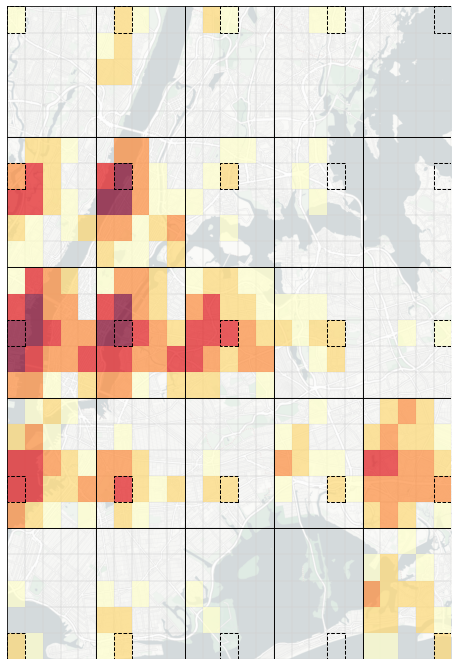

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制每个镶嵌小网格的轮廓
ax = (
    draw_base
    .plot(facecolor='none', edgecolor='lightgrey', ax=ax,
          linewidth=0.3)
)

# 绘制每个镶嵌小网格的下车记录数热力分布
ax = (
    draw_base
    .assign(下车记录数=np.log(draw_base.下车记录数))
    .plot(column='下车记录数', scheme='NaturalBreaks', 
          k=5, cmap='YlOrRd', ax=ax, alpha=0.7)
)

# 绘制原始网格的框架
ax = manhattan_grids.plot(ax=ax, facecolor='none', edgecolor='black',
                          linewidth=0.8)

# 在每个原始网格中标记出对应位置的镶嵌小网格
ax = (
    draw_base
    .query('是否为目标网格 == 1')
    .plot(facecolor='none', edgecolor='black', 
          linestyle='--', ax=ax)
)

# 设置绘图区域范围
minx, miny, maxx, maxy = manhattan_grids.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# 关闭坐标轴
ax.axis('off')

# 添加在线底图
ctx.add_basemap(ax, 
                source='https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png',
                zoom=12)

# 保存图像
fig.savefig('图10.png', dpi=500, bbox_inches='tight', pad_inches=0)